## Baseline модель

- В качестве самой базовой модели была выбрана линейная регрессия без кросс-валидации и подбора гипер параметров.
- Так как достаточно быстро обучается есть возможность попробовать разные варианты обучения:
    1. Обучение только на победах белых -> прогноз ретйтинга белых
    2. Обучние только на победах черных -> прогноз ретйинга черных
    3. Обучение на ничьих -> прогноз рейтинга белых
    4. Обучение на ничьих -> прогноз рейтинга черных
    5. Обучение только на проигрышах белых -> прогноз рейтинга белых
    6. Обучение только на проигрышах черных -> прогноз рейтинга белых
    7. Усреднение по цветам моделей 1-6
    8. 
    

## Попробовать методы:
1. Квантильная регрессия (Прогнозирование медианы с помощью квантильных регрессий - это хороший способ оптимизировать MAE вместо среднеквадратичной ошибки.)
2. Байесовская линейная регрессия
3. SVR 
4. RandomForestRegressor
5. ElasticNet – линейная регрессия с l1,l2 регуляризаторами
6. Градиентный бустинг (xgboost)

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression
from sklearn import model_selection as ms
from scipy.stats import pearsonr

from warnings import simplefilter

rand_st=4
simplefilter("ignore") 

In [2]:
elos=pd.read_csv(r'C:\Users\Asus\PredictingRatings\data\clean_elos.csv')
elos.head()

,WhiteElo,BlackElo,MeanElos,DiffElos,SumElos
0,2354,2411,2382,57,4765
1,1915,1999,1957,84,3914
2,2446,2191,2318,255,4637
3,2168,2075,2121,93,4243
4,2437,2254,2345,183,4691


In [3]:
features=pd.read_csv(r'C:\Users\Asus\PredictingRatings\data\features.csv')
print(features.info())
print(features.shape)
features.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24255 entries, 0 to 24254
Columns: 233 entries, Result to InsufficientMaterial
dtypes: float64(111), int64(122)
memory usage: 43.1 MB
None
(24255, 233)


,Result,NumMoves,MeanScore,ModeScore,FinalScore,FullMoves,MinScore,MaxScore,MedianScore,StdScore,...,EndB,EndR,EndK,WhiteСhecks,WhiteQueenCastle,BlackQueenCastle,Promotion,EnPassant,CanClaimDraw,InsufficientMaterial
count,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,...,24255.000000,24255.00000,24255.0,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000,24255.000000
mean,0.544877,42.252690,30.881103,11.907442,111.901711,83.967223,-794.591878,988.643950,68.913894,314.678490,...,0.631293,1.03892,1.0,2.015584,1.457308,0.910740,0.064069,0.061637,0.035415,0.000783
std,0.417736,16.235593,233.709202,445.214702,2310.851869,32.489872,2126.099646,2275.840558,64.170646,475.478471,...,0.676858,0.74847,0.0,2.874868,4.179615,3.663225,0.291749,0.245589,0.184831,0.027978
min,0.000000,10.000000,-2162.262500,-11447.000000,-12261.000000,19.000000,-12348.000000,-51.000000,0.000000,7.795716,...,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,31.000000,-60.758665,0.000000,-362.000000,61.000000,-482.000000,67.000000,30.000000,61.336328,...,0.000000,0.00000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,40.000000,24.563636,0.000000,0.000000,79.000000,-75.000000,156.000000,49.000000,145.621548,...,1.000000,1.00000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,51.000000,123.987715,26.000000,546.500000,102.000000,-18.000000,700.000000,84.000000,291.317992,...,1.000000,2.00000,1.0,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,165.000000,2073.289256,11259.000000,12337.000000,329.000000,26.000000,12352.000000,784.000000,3962.575036,...,2.000000,2.00000,1.0,71.000000,35.000000,36.000000,4.000000,2.000000,1.000000,1.000000


In [5]:
target_white=elos['WhiteElo']
target_black=elos['BlackElo']
target_mean=elos['MeanElos']
target_diff=elos['DiffElos']
target_sum=elos['SumElos']

#### 1. Обучение только на победах белых -> прогноз ретйтинга белых

In [13]:
start = time.time()
lr_1 = LinearRegression()
features_white = features[features['Result']==1]
target_white1=target_white[target_white.index.isin(features1.index)]
print(features_white.shape)
print(target_white1.shape)
lr_1.fit(features_white, target_white1)
white_pred1 = lr_1.predict(features_white)
full_time1=round(time.time() - start,3)
print(full_time1, 'c')

(9651, 233)
(9651,)
0.16 c


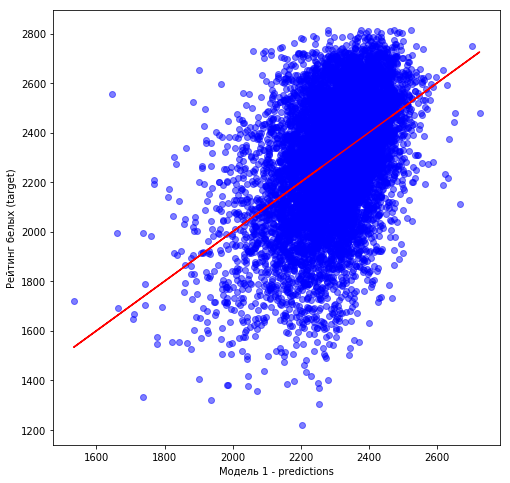

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(white_pred1,target_white1, color = 'b',alpha=0.5)
plt.xlabel('Модель 1 - predictions')
plt.ylabel('Рейтинг белых (target)')
# Линия тренда
z = np.polyfit(white_pred1,target_white1, 1)
p = np.poly1d(z)
plt.plot(white_pred1,p(white_pred1),"r")
plt.show()

In [19]:
mae1=mae(target_white1,white_pred1)
print ('MAE = {:.3f}'.format(mae1))
rmse1 = (mse(target_white1, white_pred1))**0.5
print ('RMSE = {:.3f}'.format(rmse))
corr_coef1 = pearsonr(target_white1, white_pred1)
print("Correlation coefficient = {:.3f}".format(corr_coef[0]))

MAE = 175.594
RMSE = 221.354
Correlation coefficient = 0.454


In [30]:
output = pd.DataFrame([[str(lr_1), mae1,rmse1, corr_coef1[0],full_time1,'Обучение только на победах белых -> прогноз ретйтинга белых']],
                   columns=['Модель', 'MAE','RMSE','Коэффициент корр. Пирсона', 'Время работы (c)', 'Комментарий'])
output.to_excel(r'C:\Users\Asus\PredictingRatings\models\results.xlsx',index=False)